# Guided Project: Answering Business Questions using SQL

The goal is to apply SQL skills to answer business questions. For every task, we need to:
1. Write a SQL query to extract the relevant data
2. Create plots where necessary to visualize the data
3. Write a short paragraph, draw conclusions and explain data and visualizations.

The database we look at is [`chinook.db`](https://github.com/lerocha/chinook-database), a sample database available for various Database Management Systems using SQL. The image of the database schema, provided by Dataquest.io, can be found [here](https://s3.amazonaws.com/dq-content/191/chinook-schema.svg).

As an anticipation of database locking during the project, a file `chinook-unmodified.db` is also stored locally.

## 0. Defining Query Functions

We first define several query functions to run a SQL query related to the `chinook` database and return a Pandas' DataFrame, to run a SQL command related to `chinook.db`, as well as to show all data sets that are in the type `table` or `view`.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

def run_query(q):
    with sqlite3.connect("chinook.db") as conn:
        return pd.read_sql(q, conn)

def run_command(command):
    with sqlite3.connect("chinook.db") as conn:
        conn.isolation_level = None # Autocommit any changes (SOON).
        conn.execute(command)

def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table", "view")
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


We can see that there are ten tables in `chinook.db`, all of which can be seen from [this schema](https://s3.amazonaws.com/dq-content/191/chinook-schema.svg).

## 1. Business Question: Finding Out Most Sold-out Genres in USA

To find out the most sold-out genres in USA, we create two SQL queries `q1a` and `q1b`.

The first query `q1a` mainly joins the table `invoice_line` (which has a role similar to "smallest part", symbolized by its primary key not being contained in any other tables, see the schema) with the tables) `invoice`, `track`, and `genre`. It then selects USA as the corresponding billing country, and counts the number of track quantities bought for each genre. The query returns song genres along with its number of tracks.

The second query `q1b`sorts the table produced by `q1a` based on the track number and adds a column of track number percentages.

We then execute the query `q1b` and plot the DataFrame result using `matplotlib.pyplot`.

                genre  number_of_tracks  percentage_of_total_tracks
0                Rock               561                   53.377735
1  Alternative & Punk               130                   12.369172
2               Metal               124                   11.798287
3            R&B/Soul                53                    5.042816
4               Blues                36                    3.425309


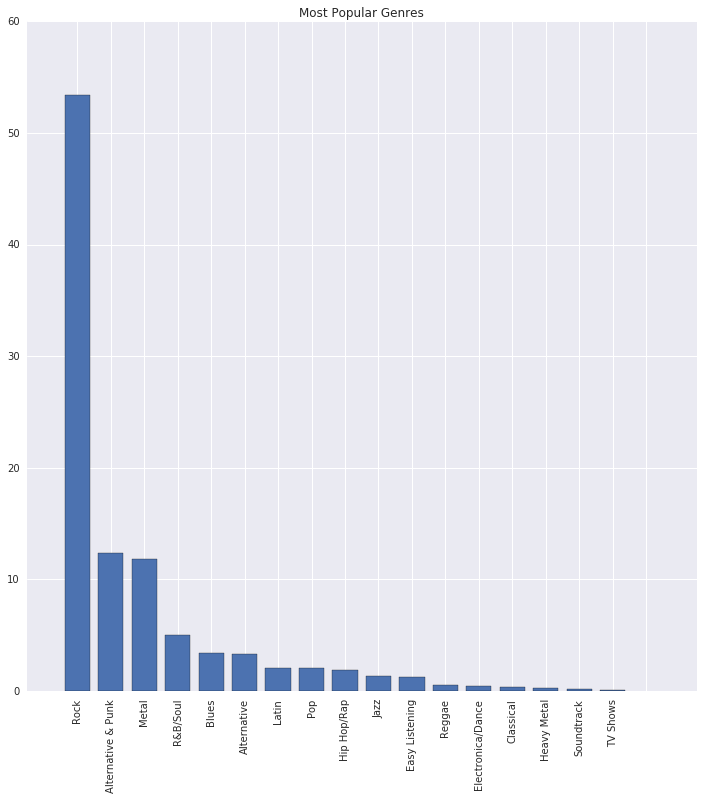

In [2]:
q1a = '''
SELECT
    g.name AS genre,
    SUM(il.quantity) AS number_of_tracks
FROM invoice i
JOIN invoice_line il
    ON i.invoice_id == il.invoice_id
    AND i.billing_country == "USA"
JOIN track t ON il.track_id == t.track_id
JOIN genre g ON t.genre_id == g.genre_id
GROUP BY g.name
'''

q1b = '''
WITH gnt AS (''' + q1a + ''')
SELECT
    *,
    number_of_tracks * 100.0 / (
        SELECT SUM(number_of_tracks) FROM gnt
    ) AS percentage_of_total_tracks
FROM gnt
ORDER BY number_of_tracks DESC
'''

genre_num_track = run_query(q1b)
print(genre_num_track.head())

# Plot the result.
fig, ax = plt.subplots(figsize = (12, 12))
genres = genre_num_track["genre"] # For easiness
bar_positions = 2*np.arange(len(genres)) + 2.25
bar_heights = genre_num_track["percentage_of_total_tracks"]
ax.bar(bar_positions, bar_heights, width = 1.5)
ax.set_xticks(range(3, 38, 2))
ax.set_xlim(0, 40)
ax.set_xticklabels(list(genres), rotation = 90)
ax.set_title("Most Popular Genres")
plt.show()

Based on the bar graph, the three music genres that has the highest number of track sales are Rock, Alternative & Punk, and Metal.

Furthermore, we can make a recommendation for the three artists whose albums should be purchased for the store, based on sales of tracks from their genres. We create a third query to select the artist with the largest number of tracks for each genre Rock, Alternative & Punk and Metal.

In [3]:
q1c = '''
SELECT
    g.name AS genre,
    ar.name AS artist,
    SUM(il.quantity) AS number_of_tracks
FROM invoice i
JOIN invoice_line il
    ON i.invoice_id == il.invoice_id
    AND i.billing_country == "USA"
JOIN track t ON il.track_id == t.track_id
JOIN genre g ON t.genre_id == g.genre_id
JOIN album a ON t.album_id == a.album_id
JOIN artist ar ON a.artist_id == ar.artist_id
WHERE g.name IN ("Rock", "Alternative & Punk", "Metal")
GROUP BY g.name, ar.name, ar.artist_id
'''

q1d = '''
SELECT
    genre,
    MAX(number_of_tracks) AS max_num_of_tracks
FROM (''' + q1c + ''')
GROUP BY genre
'''

q1e = '''
WITH gar AS (''' + q1c + '''),
    gmaxtr AS (''' + q1d + ''')
SELECT
    gar.*
FROM gar
JOIN gmaxtr ON gar.genre == gmaxtr.genre
WHERE gar.number_of_tracks == gmaxtr.max_num_of_tracks
'''

three_top_genres_artist_reps = run_query(q1e)
print(three_top_genres_artist_reps)

                genre         artist  number_of_tracks
0  Alternative & Punk      Green Day                32
1  Alternative & Punk         R.E.M.                32
2               Metal  Black Sabbath                24
3                Rock      Van Halen                43


From this, we can conclude that the suggested representative artist of Rock is Van Halen, and the suggested representative artist of Metal is Black Sabbath. Meanwhile there are two artists to recommend for Alternative & Punk genre: Green Day and R.E.M.

## 2. Business Question: Analyzing the Customer Purchases of Sales Support Agents (SSA)

We create a SQL query for analyzing which Sales Support Agents (SSA) performs the best and the worst.

In [4]:
q2 = '''
SELECT
    e.employee_id,
    e.first_name || " " || e.last_name AS employee_name,
    e.hire_date,
    COUNT(DISTINCT(c.customer_id)) AS num_of_customers,
    COUNT(i.invoice_id) AS num_of_transactions,
    SUM(i.total) AS total_sales
FROM employee e
LEFT JOIN customer c ON e.employee_id == c.support_rep_id
JOIN invoice i ON c.customer_id == i.customer_id
WHERE e.title == "Sales Support Agent"
GROUP BY 1, 2, 3
ORDER BY total_sales DESC
'''

ssa_sales = run_query(q2)
print(ssa_sales)

   employee_id  employee_name            hire_date  num_of_customers  \
0            3   Jane Peacock  2017-04-01 00:00:00                21   
1            4  Margaret Park  2017-05-03 00:00:00                20   
2            5  Steve Johnson  2017-10-17 00:00:00                18   

   num_of_transactions  total_sales  
0                  212      1731.51  
1                  214      1584.00  
2                  188      1393.92  


There are only three SSAs in `chinook.db`. Notice that the `total_sales` variance seems to be related with how long they have worked: the earlier they were hired, the larger their sales number is.

It is more appropriate to see the average sales per day (or per year) each SSA make. I was initially thinking of assuming the current date of measurement as the date `chinook.db` was first posted on Github (i.e. on May 28, 2017). However, one of the SSAs has a hire date later than this date. I henceforth decided to skip this part.

## 3. Business Question: Analyzing the Customer Purchases Based on Countries

We first group the data set by the country, then make the columns reflecting total sales, total number of customers, and the number of total order.

We then assign another grouping based on whether there is just one purchase from the corresponding country, and assign the aggregate variables of sales average and order average.

In [5]:
q3a = '''
SELECT
    c.country,
    SUM(i.total) AS tot_sales,
    COUNT(DISTINCT(c.customer_id)) AS tot_customers,
    COUNT(*) AS tot_order
FROM customer c
JOIN invoice i ON c.customer_id == i.customer_id
GROUP BY c.country
'''

q3b = '''
SELECT
    country,
    tot_sales,
    tot_customers,
    tot_order,
    tot_sales * 1.0 / tot_customers AS avg_sales_per_customer,
    tot_order * 1.0 / tot_customers AS avg_order,
    CASE
        WHEN tot_customers == 1 THEN 1
        ELSE 0
    END AS is_other
FROM (''' + q3a + ''')
ORDER BY is_other, tot_sales DESC
'''

country_sales = run_query(q3b)
print(country_sales)

           country  tot_sales  tot_customers  tot_order  \
0              USA    1040.49             13        131   
1           Canada     535.59              8         76   
2           Brazil     427.68              5         61   
3           France     389.07              5         50   
4          Germany     334.62              4         41   
5   Czech Republic     273.24              2         30   
6   United Kingdom     245.52              3         28   
7         Portugal     185.13              2         29   
8            India     183.15              2         21   
9          Ireland     114.84              1         13   
10           Spain      98.01              1         11   
11           Chile      97.02              1         13   
12       Australia      81.18              1         10   
13         Finland      79.20              1         11   
14         Hungary      78.21              1         10   
15          Poland      76.23              1         10 

Now that the data is inferrable, a series of visualizations is created in order to recommend which countries having the best potential for market growth.

- For each dimension `d`, we plot the relation between country vs `d`.
- In some circumstances, we may ignore countries with a single customer (`is_other = 1`).
- The best dimension may be `avg_sales_per_customer`.

### <span style = "color: red">Warning: Need more details (6/8)</span>

/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


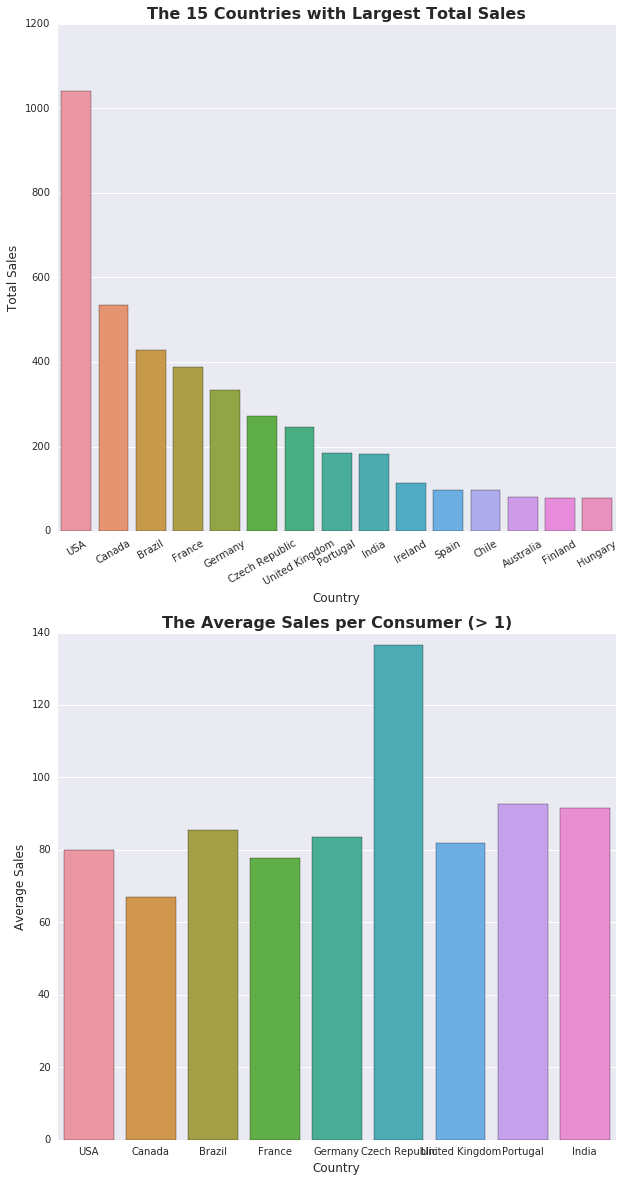

In [6]:
fig, ax = plt.subplots(2, 1, figsize = (10, 20))

sns.barplot(x = "country",
            y = "tot_sales",
            label = "small",
            data = country_sales[:15],
            ax = ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation = 30)
ax[0].set_title("The 15 Countries with Largest Total Sales", fontsize = 16, weight = "bold")
ax[0].set_xlabel("Country", fontsize = 12)
ax[0].set_ylabel("Total Sales", fontsize = 12)

sns.barplot(x = "country",
            y = "avg_sales_per_customer",
            data = country_sales[country_sales["is_other"] == 0],
            ax = ax[1])
ax[1].set_title("The Average Sales per Consumer (> 1)", fontsize = 16, weight = "bold")
ax[1].set_xlabel("Country", fontsize = 12)
ax[1].set_ylabel("Average Sales", fontsize = 12)

From the above pictures:
1. USA is the country with the largest amount of sales.
2. Czech Republic seems to be able to grow with the larger sale amount per consumer.

## 4. Analyzing Individual and Album Purchases

Suppose that the management are considering altering their purchasing method to increase profit, so that consumers can choose only the most popular tracks from each album from record companies instead of buying every track in an album. We want to compare the number of purchases on individual tracks versus on full albums.

The corner cases that can prevent our accuracy might be (1) an album with 1-2 tracks, which will be sold less since one can just pick these tracks as part of a collection of individual tracks, and (2) a manual selection of the entire tracks of an album along with other individual tracks. Since the purpose of this analysis is to maximize profit, we can safely ignore case (1). Meanwhile, our management's separate analysis reasons that case (2) does not happen often, so we can also safely ignore case (2).

We classify an invoice as either an album purchase or not, then calculate the number and the percentage of invoices.

In [7]:
q4_album_track_num = '''
SELECT
    a.album_id,
    COUNT(t.track_id) AS num_tracks
FROM album a
JOIN track t ON a.album_id = t.album_id
GROUP BY a.album_id
'''

q4_invoice_track_etc = '''
SELECT
    i.invoice_id,
    il.track_id,
    atn.album_id,
    atn.num_tracks
FROM invoice i
JOIN invoice_line il ON i.invoice_id = il.invoice_id
JOIN track t ON t.track_id = il.track_id
JOIN (''' + q4_album_track_num + ''') atn ON atn.album_id = t.album_id
'''

q4_invoice_is_whole_album = '''
SELECT
    invoice_id,
    CASE
        WHEN (
            COUNT(DISTINCT album_id) == 1
        ) AND (
            COUNT(*) == num_tracks
        ) THEN 1
        ELSE 0
    END AS is_whole_album
FROM (''' + q4_invoice_track_etc + ''')
GROUP BY invoice_id
'''

q4_indiv_vs_album = '''
WITH iiwa AS (''' + q4_invoice_is_whole_album + ''')
SELECT
    CASE
        WHEN is_whole_album == 1 THEN "Yes"
        ELSE "No"
    END is_whole_album,
    COUNT(*) num_invoices,
    COUNT(*) * 100.0 / (SELECT COUNT(*) FROM iiwa) percent_invoices
FROM iiwa 
GROUP BY is_whole_album
'''

invoice_compare = run_query(q4_indiv_vs_album)
print(invoice_compare.head(20))

  is_whole_album  num_invoices  percent_invoices
0             No           500         81.433225
1            Yes           114         18.566775


Around $80\%$ of sales comprises individual tracks, which is quite significant. Therefore we may recommend the Chinook store to change the purchase system orientation into individual tracks.

## 5. Conclusion
